{% include toc title="In This Chapter" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-ship" aria-hidden="true"></i> Chapter 13 - NETCDF 4 Climate Data in Open Source Python 

In this chapter, you will learn how to work with Climate Data Sets (MACA v2 for the United states) stored in netcdf 4 format using open source **Python**.

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

After completing this chapter, you will be able to:

* Summarize MACA v 2 climate data stored in netcdf 4 format by seasons across all time periods using `xarray`.
* Summarize MACA v 2 climate data stored in netcdf 4 format by seasons and across years using `xarray`.

## <i class="fa fa-check-square-o fa-2" aria-hidden="true"></i> What You Need

You will need a computer with internet access to complete this lesson and the earth-analytics-python
conda environment installed.

</div>

## Subset MACA 2 Climate Data in NetCDF 4 Format By Time and Spatial Extents

In this lesson, you will learn how to subset MACA v2 climate data using the open 
source Python packages `xarray` and `regionmask`.

In [1]:
# Make sure ea dir exists - if not create it
import warnings
import os
import earthpy as et
ea_path = os.path.join(et.io.HOME, 'earth-analytics', 'data')

if not os.path.exists(ea_path):
    os.makedirs(ea_path)

warnings.filterwarnings("ignore")

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et
import xarray as xr
# Spatial subsetting of netcdf files
import regionmask


# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

# Optional - set your working directory if you wish to use the data
# accessed lower down in this notebook (the USA state boundary data)
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

## Spatial Subsets of Data Using an AOI

In the previous lesson, you learned how to select a single point and extract 
temperature data at that location. You can also create areas of interest 
(AOIs) that define the geographic region that you wish to extract data for. 

Below you will learn how to use a shapefile that contains a boundary
area of interest that you wish to subset data for. You will then learn 
how to subset the data using the 

1. geographic boundary extent of the AOI (a rectangular extent) and
2. using the actual shape boundary of the AOI (example: the state of California)

To begin, you will open up a new netcdf file. This file contains 
future projected maximum temperature data for the Continental United States(CONUS).  

In [3]:
# Get netcdf file
data_path_monthly = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_tasmax_BNU-ESM_r1i1p1_rcp45_2006_2099_CONUS_monthly.nc'

# Open up the data
with xr.open_dataset(data_path_monthly) as file_nc:
    monthly_forecast_temp_xr = file_nc

# View xarray object
monthly_forecast_temp_xr

<xarray.Dataset>
Dimensions:          (crs: 1, lat: 585, lon: 1386, time: 1128)
Coordinates:
  * lat              (lat) float64 25.06 25.1 25.15 25.19 ... 49.31 49.35 49.4
  * crs              (crs) int32 1
  * lon              (lon) float64 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
  * time             (time) object 2006-01-15 00:00:00 ... 2099-12-15 00:00:00
Data variables:
    air_temperature  (time, lat, lon) float32 ...
Attributes:
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    title:                           Monthly aggregation of downscaled daily ...
    summary:                         This archive contains monthly downscaled...
    keywords:                        monthly, precipitation, maximum temperat...
    keywords_vocabulary:             
    standard_name_vocabulary:        CF-1.0
    history:                         No revisions.
    comment:                         
    geospatial_bounds:               POLYGON((-124.7722 25.0631,-124.7722 49....
    geospatial_lat_min:              25.0631
    geospatial_lat_max:              49.3960
    geospatial_lon_min:              -124.7722
    geospatial_lon_max:              -67.0648
    geospatial_lat_units:            decimal degrees north
    geospatial_lon_units:            decimal degrees east
    geospatial_lat_resolution:       0.0417
    geospatial_lon_resolution:       0.0417
    geospatial_vertical_min:         0.0
    geospatial_vertical_max:         0.0
    geospatial_vertical_resolution:  0.0
    geospatial_vertical_positive:    up
    time_coverage_start:             2091-01-01T00:0
    time_coverage_end:               2095-12-31T00:00
    time_coverage_duration:          P5Y
    time_coverage_resolution:        P1M
    date_created:                    2014-05-15
    date_modified:                   2014-05-15
    date_issued:                     2014-05-15
    creator_name:                    John Abatzoglou
    creator_url:                     http://maca.northwestknowledge.net
    creator_email:                   jabatzoglou@uidaho.edu
    institution:                     University of Idaho
    processing_level:                GRID
    project:                         
    contributor_name:                Katherine C. Hegewisch
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

### Open A Shapefile to Use as an AOI

Often you want to subset and summarize climate data by specific regions of 
interest. In the example below, you will open a natural earth layer that 
contains state and region boundaries. You will extract a state boundary (California)
within the United States to use as an AOI.

In [4]:
# Download natural earth data which contains state boundaries to generate AOI
et.data.get_data(
    url="https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_1_states_provinces_lakes.zip")

states_path = "earthpy-downloads/ne_50m_admin_1_states_provinces_lakes"
states_path = os.path.join(
    states_path, "ne_50m_admin_1_states_provinces_lakes.shp")

states_gdf = gpd.read_file(states_path)
states_gdf.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,name_nl,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,ne_id,geometry
0,Admin-1 scale rank,2,AUS-2651,2651,AU-WA,None,AU,6,Western Australia,None,...,West-Australië,Australia Zachodnia,Austrália Ocidental,Западная Австралия,Western Australia,Batı Avustralya,Tây Úc,西澳大利亚州,1159315805,"MULTIPOLYGON (((113.13181 -25.95199, 113.14823..."
1,Admin-1 scale rank,2,AUS-2650,2650,AU-NT,None,AU,6,Northern Territory,None,...,Noordelijk Territorium,Terytorium Północne,Território do Norte,Северная территория,Northern Territory,Kuzey Toprakları,Lãnh thổ Bắc Úc,北領地,1159315809,"MULTIPOLYGON (((129.00196 -25.99901, 129.00196..."
2,Admin-1 scale rank,2,AUS-2655,2655,AU-SA,None,AU,3,South Australia,None,...,Zuid-Australië,Australia Południowa,Austrália Meridional,Южная Австралия,South Australia,Güney Avustralya,Nam Úc,南澳大利亚州,1159313267,"MULTIPOLYGON (((129.00196 -31.69266, 129.00196..."
3,Admin-1 scale rank,2,AUS-2657,2657,AU-QLD,None,AU,5,Queensland,None,...,Queensland,Queensland,Queensland,Квинсленд,Queensland,Queensland,Queensland,昆士蘭州,1159315807,"MULTIPOLYGON (((138.00196 -25.99901, 138.00174..."
4,Admin-1 scale rank,2,AUS-2660,2660,AU-TAS,None,AU,5,Tasmania,None,...,Tasmanië,Tasmania,Tasmânia,Тасмания,Tasmanien,Tasmanya,Tasmania,塔斯馬尼亞州,1159313261,"MULTIPOLYGON (((147.31246 -43.28038, 147.34238..."


In [5]:
# You will use the bounds to determine the slice values for this data
# Select any state in the CONUS that you wish here! California is the default
cali_aoi = states_gdf[states_gdf.name == "California"]
# Get the total spatial extent for California
cali_aoi.total_bounds

array([-124.37165376,   32.53336527, -114.12501824,   42.00076797])

Next, convert the bounds of your AOI into the min and max longitude
and latitude values. You will use these values to `slice` your data.

In [6]:
# Get lat min, max
aoi_lat = [float(cali_aoi.total_bounds[1]), float(cali_aoi.total_bounds[3])]
aoi_lon = [float(cali_aoi.total_bounds[0]), float(cali_aoi.total_bounds[2])]
# Notice that the longitude values have negative numbers
# we need these values in a global crs so we can subtract from 360
aoi_lat, aoi_lon

([32.533365269889316, 42.00076797479207],
 [-124.3716537616361, -114.12501823892204])

The netcdf files use a global lat/lon rather than positive and negative
longitude values. To ensure you are subsetting the data for the correct
region, you can add 360 degrees to each longitude value which represent the 
min x and max x values for the extent.


In [7]:
# The netcdf files use a global lat/lon so adjust values accordingly
aoi_lon[0] = aoi_lon[0] + 360
aoi_lon[1] = aoi_lon[1] + 360
aoi_lon

[235.62834623836392, 245.87498176107795]

Once you have your data AOI defined, you can slice out the 
AOI region using xarray `slice`.

In [8]:
# Slice the data by time and spatial extent
start_date = "2010-01-15"
end_date = "2010-02-15"

two_months_cali = monthly_forecast_temp_xr["air_temperature"].sel(
    time=slice(start_date, end_date),
    lon=slice(aoi_lon[0], aoi_lon[1]),
    lat=slice(aoi_lat[0], aoi_lat[1]))
two_months_cali

<xarray.DataArray 'air_temperature' (time: 2, lat: 227, lon: 246)>
[111684 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 32.56 32.6 32.65 32.69 ... 41.85 41.9 41.94 41.98
  * lon      (lon) float64 235.6 235.7 235.7 235.8 ... 245.7 245.8 245.8 245.9
  * time     (time) object 2010-01-15 00:00:00 2010-02-15 00:00:00
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days
    _ChunkSizes:    [ 10  44 107]

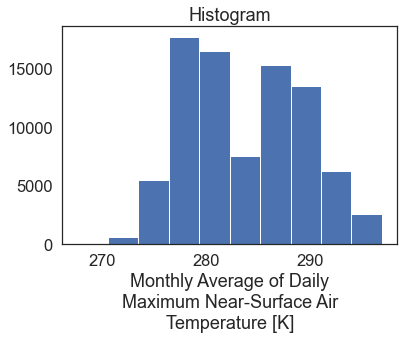

In [9]:
# Plot a quick histogram
two_months_cali.plot()
plt.show()

Remember that these data are spatial. Below you 
plot each time step as a raster dataset. Notice that this spatial extent
is a rectangle representing the entire rectangular extent for the 
state of California.

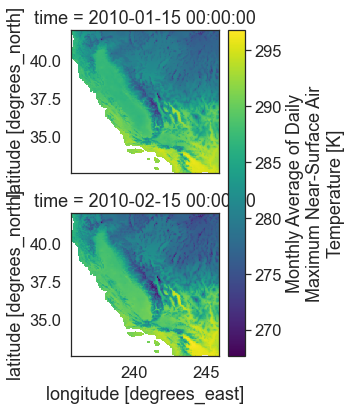

In [10]:
# Spatial Plot for the selected AOI (California)
two_months_cali.plot(col='time',
                     col_wrap=1)

plt.show()

In [11]:
# Only subset by location / not time
cali_ts = monthly_forecast_temp_xr["air_temperature"].sel(
    lon=slice(aoi_lon[0], aoi_lon[1]),
    lat=slice(aoi_lat[0], aoi_lat[1]))
cali_ts

<xarray.DataArray 'air_temperature' (time: 1128, lat: 227, lon: 246)>
[62989776 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 32.56 32.6 32.65 32.69 ... 41.85 41.9 41.94 41.98
  * lon      (lon) float64 235.6 235.7 235.7 235.8 ... 245.7 245.8 245.8 245.9
  * time     (time) object 2006-01-15 00:00:00 ... 2099-12-15 00:00:00
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days
    _ChunkSizes:    [ 10  44 107]

Calculate a summary of max temperature over time for california

In [12]:
# notnull = pd.notnull(cali_ts)
# notnull

In [13]:
# Time series plot of max temperature per year. for California
# You will get a RuntimeWarning warning here because of nan values...
# This is the max value in each pixel across all months for each year
cali_annual_max = cali_ts.groupby('time.year').max(skipna=True)
cali_annual_max

<xarray.DataArray 'air_temperature' (year: 94, lat: 227, lon: 246)>
array([[[      nan,       nan,       nan, ..., 314.2675 , 314.05508,
         313.95047],
        [      nan,       nan,       nan, ..., 314.08972, 313.86816,
         313.9082 ],
        [      nan,       nan,       nan, ..., 314.02127, 313.8809 ,
         313.9658 ],
        ...,
        [      nan,       nan,       nan, ..., 304.58743, 304.74078,
         304.8877 ],
        [      nan,       nan,       nan, ..., 303.80627, 303.83685,
         304.6529 ],
        [      nan, 293.99442, 294.31528, ..., 302.92322, 302.578  ,
         303.59604]],

       [[      nan,       nan,       nan, ..., 314.5754 , 314.44275,
         314.34146],
        [      nan,       nan,       nan, ..., 314.50024, 314.32486,
         314.3367 ],
        [      nan,       nan,       nan, ..., 314.4508 , 314.33475,
         314.3861 ],
...
        [      nan,       nan,       nan, ..., 306.28198, 306.4167 ,
         306.61166],
        [      nan,       nan,       nan, ..., 305.46466, 305.49435,
         306.3104 ],
        [      nan, 296.4974 , 296.71976, ..., 304.55817, 304.22375,
         305.2304 ]],

       [[      nan,       nan,       nan, ..., 316.17175, 315.9877 ,
         315.91992],
        [      nan,       nan,       nan, ..., 316.05585, 315.89587,
         315.90164],
        [      nan,       nan,       nan, ..., 316.0458 , 315.94336,
         315.96744],
        ...,
        [      nan,       nan,       nan, ..., 309.6978 , 310.04214,
         310.2721 ],
        [      nan,       nan,       nan, ..., 308.9082 , 308.9424 ,
         309.8799 ],
        [      nan, 296.43567, 296.677  , ..., 307.94104, 307.59906,
         308.6584 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 32.56 32.6 32.65 32.69 ... 41.85 41.9 41.94 41.98
  * lon      (lon) float64 235.6 235.7 235.7 235.8 ... 245.7 245.8 245.8 245.9
  * year     (year) int64 2006 2007 2008 2009 2010 ... 2095 2096 2097 2098 2099

### Calculate Annual Summary Data
You can calculate summary values for your aoi using the `.groupby`
method. Below you calculate the max value for each raster in the 
time series 

`.max(["lat", "lon"]` tells xarray to calculate the max on the entire raster.

the data are grouped by year. 


In [14]:
cali_annual_max_val = cali_annual_max.groupby("year").max(["lat", "lon"])
cali_annual_max_val

<xarray.DataArray 'air_temperature' (year: 94)>
array([320.67538, 322.2723 , 320.86505, 321.88   , 321.55954, 320.30484,
       322.17026, 322.1134 , 322.16568, 321.32007, 321.67624, 322.07996,
       321.5724 , 320.7888 , 321.4106 , 320.6512 , 322.2032 , 322.18158,
       322.05664, 322.96497, 322.20325, 321.28458, 321.51407, 324.0671 ,
       323.02896, 322.10184, 322.73853, 322.56485, 321.98178, 322.4918 ,
       322.19852, 322.44962, 321.97635, 322.33276, 322.55652, 322.4373 ,
       322.4933 , 323.7776 , 323.3054 , 321.22037, 322.00476, 322.40897,
       323.43805, 323.57452, 322.63904, 321.85776, 324.09442, 323.27408,
       323.67053, 322.62167, 323.70203, 322.82205, 321.93048, 323.48462,
       323.89087, 323.4939 , 324.15057, 322.88406, 322.6229 , 324.0509 ,
       323.06467, 324.27808, 324.30505, 323.27487, 323.3609 , 324.03644,
       323.1147 , 324.6987 , 322.52747, 323.00424, 324.0726 , 322.78583,
       323.49216, 322.4643 , 321.52664, 323.14383, 323.44632, 323.4093 ,
       324.51718, 322.68958, 324.83566, 323.24158, 323.22598, 323.8113 ,
       323.70255, 321.93524, 325.1739 , 322.6527 , 323.33313, 323.01407,
       323.40854, 323.8004 , 321.59985, 324.6846 ], dtype=float32)
Coordinates:
  * year     (year) int64 2006 2007 2008 2009 2010 ... 2095 2096 2097 2098 2099

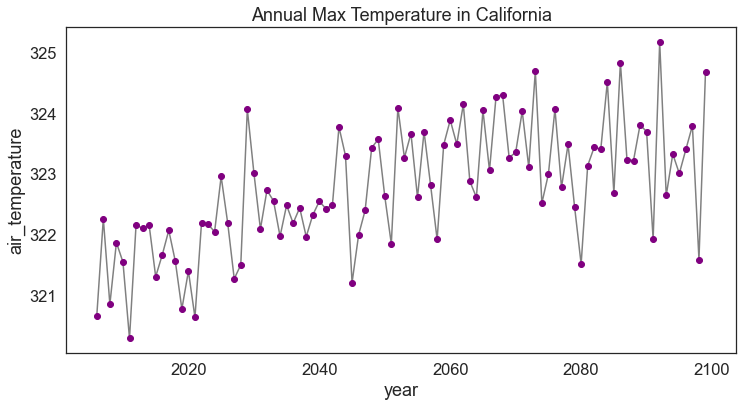

In [15]:
# Plot the data
f, ax = plt.subplots(figsize=(12, 6))
cali_annual_max_val.plot.line(hue='lat',
                              marker="o",
                              ax=ax,
                              color="grey",
                              markerfacecolor="purple",
                              markeredgecolor="purple")
ax.set(title="Annual Max Temperature (K) in California")
plt.show()

## Subset a netcdf4 Using a Shapefile Feature or Features

Above you created a rectangular spatial subset and plotted the data. 
Sometimes however you may have an AOI that is a specific polygon boundary.
Below you will modify your subset to represent just the region of the 
state of California. You will use the `regionmask` package to create
this mask.

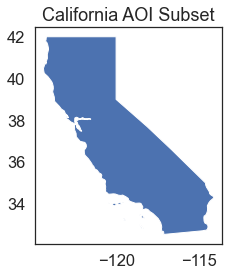

In [16]:
# This is the AOI of interest. You only want to calculate summary values for
# pixels within this AOI rather the entire rectangular spatial extent.
f, ax = plt.subplots()
cali_aoi.plot(ax=ax)
ax.set(title="California AOI Subset")

plt.show()

You will use the cali_aoi object created above to first create a 
mask.

In [17]:
cali_aoi

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,name_nl,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,ne_id,geometry
53,Admin-1 scale rank,2,USA-3521,3521,US-CA,http://en.wikipedia.org/wiki/California,US,8,California,CA|Calif.,...,Californië,Kalifornia,Califórnia,Калифорния,Kalifornien,Kaliforniya,California,加利福尼亚州,1159308415,"MULTIPOLYGON (((-114.61054 34.99112, -114.6109..."


The `regionmask.from_geopandas()` function takes a `Geopandas` polygon object
and creates a mask or set of masks according to the polygon features in the 
original shapefile. Below you create a mask for just a single aoi - 
the state of California.
# HIDE THIS AND BELOW??

In [18]:
# Create the region mask object - this is used to identify each region
cali_region = regionmask.from_geopandas(cali_aoi,
                                        names="name",
                                        name="name",
                                        abbrevs="iso_3166_2")
cali_region

<regionmask.Regions>
Name:     name

Regions:
 53  US-CA  California

[1 regions]

Plot the regions.

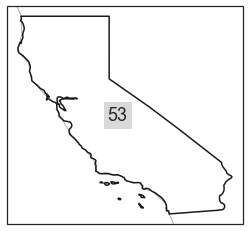

In [19]:
cali_region.plot()
plt.show()

Next you use the regionmask object  you create the spatial mask using the shapefile mask object
that you created above and the lat and longitude values from the 
xarray object that contains the air temperature data. 

In [20]:
# Create a masked object
temp_masked = cali_region.mask(monthly_forecast_temp_xr)
temp_masked

<xarray.DataArray 'region' (lat: 585, lon: 1386)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 25.06 25.1 25.15 25.19 ... 49.27 49.31 49.35 49.4
  * lon      (lon) float64 235.2 235.3 235.3 235.4 ... 292.8 292.9 292.9 292.9

In [21]:
temp_masked.min(), temp_masked.max()

(<xarray.DataArray 'region' ()>
 array(53.),
 <xarray.DataArray 'region' ()>
 array(53.))

In [22]:
# Mask the california subset that you created above
two_months_cali_masked = two_months_cali.where(temp_masked == 53)
two_months_cali_masked

<xarray.DataArray 'air_temperature' (time: 2, lat: 227, lon: 246)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 32.56 32.6 32.65 32.69 ... 41.85 41.9 41.94 41.98
  * lon      (lon) float64 235.6 235.7 235.7 235.8 ... 245.7 245.8 245.8 245.9
  * time     (time) object 2010-01-15 00:00:00 2010-02-15 00:00:00
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days
    _ChunkSizes:    [ 10  44 107]

Finally you can plot your data. Notice that now the raster values
only represent the pixels within the state of California!

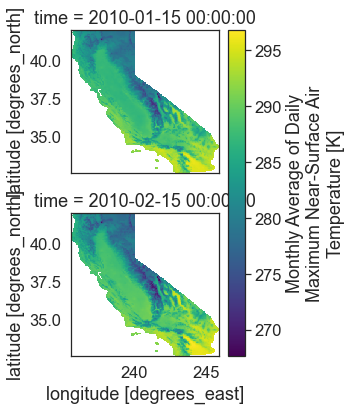

In [23]:
# Plot the data
two_months_cali_masked.plot(col='time',
                            col_wrap=1)
plt.show()

In [24]:
# View summary temperature values for each time step
two_months_cali_masked.groupby('time').mean(['lat', 'lon'])

<xarray.DataArray 'air_temperature' (time: 2)>
array([286.05795, 286.02655], dtype=float32)
Coordinates:
  * time     (time) object 2010-01-15 00:00:00 2010-02-15 00:00:00

In [25]:
# Create a 3d mask - this contains the true / false values identifying pixels
# inside vs outside of the mask region
cali_mask = regionmask.mask_3D_geopandas(cali_aoi,
                                         monthly_forecast_temp_xr.lon,
                                         monthly_forecast_temp_xr.lat)
cali_mask

<xarray.DataArray 'region' (region: 1, lat: 585, lon: 1386)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * lat      (lat) float64 25.06 25.1 25.15 25.19 ... 49.27 49.31 49.35 49.4
  * lon      (lon) float64 235.2 235.3 235.3 235.4 ... 292.8 292.9 292.9 292.9
  * region   (region) int64 53

To make processing a bit quicker, below you slice out two months of the data.

In [26]:
# Slice out two months of data
two_months = monthly_forecast_temp_xr.sel(
    time=slice('2099-10-25', '2099-12-15'))

Next, apply the mask for just the state of California to the data. 

In [27]:
# Apply the mask for California to the data
two_months = two_months.where(cali_mask)
two_months

<xarray.Dataset>
Dimensions:          (crs: 1, lat: 585, lon: 1386, region: 1, time: 2)
Coordinates:
  * lat              (lat) float64 25.06 25.1 25.15 25.19 ... 49.31 49.35 49.4
  * crs              (crs) int32 1
  * lon              (lon) float64 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
  * time             (time) object 2099-11-15 00:00:00 2099-12-15 00:00:00
  * region           (region) int64 53
Data variables:
    air_temperature  (time, lat, lon, region) float32 nan nan nan ... nan nan
Attributes:
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    title:                           Monthly aggregation of downscaled daily ...
    summary:                         This archive contains monthly downscaled...
    keywords:                        monthly, precipitation, maximum temperat...
    keywords_vocabulary:             
    standard_name_vocabulary:        CF-1.0
    history:                         No revisions.
    comment:                         
    geospatial_bounds:               POLYGON((-124.7722 25.0631,-124.7722 49....
    geospatial_lat_min:              25.0631
    geospatial_lat_max:              49.3960
    geospatial_lon_min:              -124.7722
    geospatial_lon_max:              -67.0648
    geospatial_lat_units:            decimal degrees north
    geospatial_lon_units:            decimal degrees east
    geospatial_lat_resolution:       0.0417
    geospatial_lon_resolution:       0.0417
    geospatial_vertical_min:         0.0
    geospatial_vertical_max:         0.0
    geospatial_vertical_resolution:  0.0
    geospatial_vertical_positive:    up
    time_coverage_start:             2091-01-01T00:0
    time_coverage_end:               2095-12-31T00:00
    time_coverage_duration:          P5Y
    time_coverage_resolution:        P1M
    date_created:                    2014-05-15
    date_modified:                   2014-05-15
    date_issued:                     2014-05-15
    creator_name:                    John Abatzoglou
    creator_url:                     http://maca.northwestknowledge.net
    creator_email:                   jabatzoglou@uidaho.edu
    institution:                     University of Idaho
    processing_level:                GRID
    project:                         
    contributor_name:                Katherine C. Hegewisch
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

Below you can see that the data for only the region of interest - 
California, is plotted. However, you have a lot of extra white space
surrounding the data.

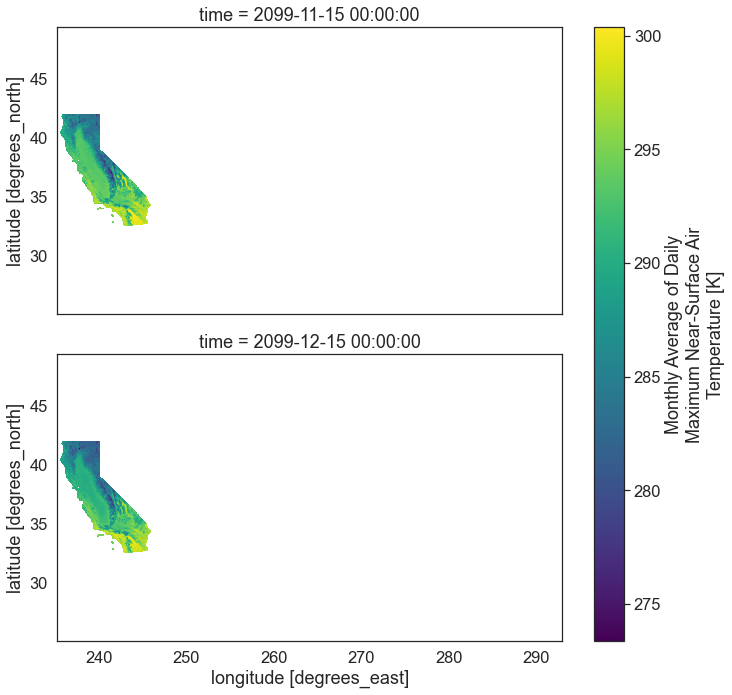

In [28]:
two_months["air_temperature"].plot(col='time',
                                   col_wrap=1,
                                   figsize=(10, 10))
plt.show()

If you slice our your data by time and lat lon and apply the mask for your 
AOI you get the d

In [29]:
two_months_masked = monthly_forecast_temp_xr["air_temperature"].sel(time=slice('2099-10-25',
                                                                               '2099-12-15'),
                                                                    lon=slice(aoi_lon[0],
                                                                              aoi_lon[1]),
                                                                    lat=slice(aoi_lat[0],
                                                                              aoi_lat[1])).where(cali_mask)
two_months_masked.dims

('time', 'lat', 'lon', 'region')

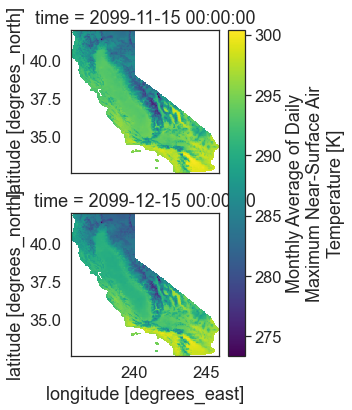

In [30]:
two_months_masked.plot(col='time', col_wrap=1)
plt.show()

## Workflow with Multiple Regions

In the example above, you had one region of interest. Below you will implement a 
workflow where you have multiple regions. For this example, you will subset multiple states
from your shapefile. 

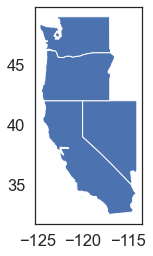

In [31]:
# Start by extracting a few states from the states_gdf
states_gdf["name"]

cali_or_wash_nev = states_gdf[states_gdf.name.isin(
    ["California", "Oregon", "Washington", "Nevada"])]
cali_or_wash_nev.plot()
plt.show()

Next, create a mask just like you did above. However this time
you will use the new extent that contains 4 states (4 regions). 

In [32]:
west_mask = regionmask.mask_3D_geopandas(cali_or_wash_nev,
                                         monthly_forecast_temp_xr.lon,
                                         monthly_forecast_temp_xr.lat)
west_mask

<xarray.DataArray 'region' (region: 4, lat: 585, lon: 1386)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * lat      (lat) float64 25.06 25.1 25.15 25.19 ... 49.27 49.31 49.35 49.4
  * lon      (lon) float64 235.2 235.3 235.3 235.4 ... 292.8 292.9 292.9 292.9
  * region   (region) int64 53 82 86 96

Below is a small helper function that grabs the AOI from a shapefile and 
returns a dictionary that you can use to slice your data. 

In [33]:
def get_aoi(shp, world=True):
    """Takes a geopandas object and converts it to a lat/ lon
    extent 

    Parameters
    -----------
    shp : geopandas object
    world : boolean

    Returns
    -------
    Dictionary of lat and lon spatial bounds
    """

    lon_lat = {}
    # Get lat min, max
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

    if world:
        aoi_lon[0] = aoi_lon[0] + 360
        aoi_lon[1] = aoi_lon[1] + 360
    lon_lat["lon"] = aoi_lon
    lon_lat["lat"] = aoi_lat
    return lon_lat


west_bounds = get_aoi(cali_or_wash_nev)

Similar to your workflow above, you can subset that data as you wish by time and 
extent. Subsetting the data will make all of your data processing faster!

In [34]:
# Slice the data
start_date = "2010-01-15"
end_date = "2010-02-15"

# Subset
two_months_west_coast = monthly_forecast_temp_xr["air_temperature"].sel(
    time=slice(start_date, end_date),
    lon=slice(west_bounds["lon"][0], west_bounds["lon"][1]),
    lat=slice(west_bounds["lat"][0], west_bounds["lat"][1]))
two_months_west_coast

<xarray.DataArray 'air_temperature' (time: 2, lat: 395, lon: 256)>
[202240 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 32.56 32.6 32.65 32.69 ... 48.85 48.9 48.94 48.98
  * lon      (lon) float64 235.3 235.4 235.4 235.4 ... 245.8 245.9 245.9 245.9
  * time     (time) object 2010-01-15 00:00:00 2010-02-15 00:00:00
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days
    _ChunkSizes:    [ 10  44 107]

Plot the data.

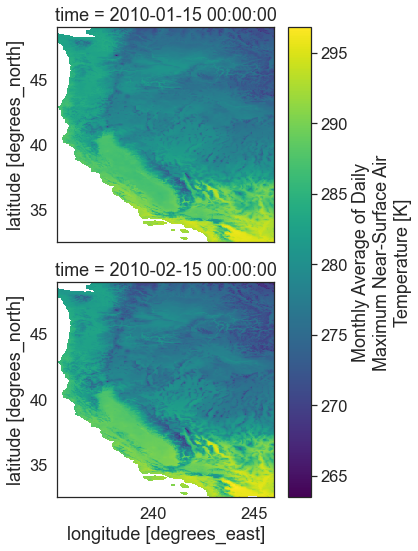

In [35]:
two_months_west_coast.plot(col="time",
                           col_wrap=1,
                           figsize=(5, 8))
plt.show()

Again following the same steps as above, you can apply your
spatial mask. This will return a new array with the air
temperature data that can be grouped by each of the 4 regions. 

In [36]:
# Apply the mask for the west coast subset
two_months_west_coast = two_months_west_coast.where(west_mask)
two_months_west_coast.dims

('time', 'lat', 'lon', 'region')

By default region mask takes the index of the geopandas 
object and uses it as a region identifier. If you remember 
from above, california was 53.

In [37]:
cali_or_wash_nev

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,name_nl,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,ne_id,geometry
53,Admin-1 scale rank,2,USA-3521,3521,US-CA,http://en.wikipedia.org/wiki/California,US,8,California,CA|Calif.,...,Californië,Kalifornia,Califórnia,Калифорния,Kalifornien,Kaliforniya,California,加利福尼亚州,1159308415,"MULTIPOLYGON (((-114.61054 34.99112, -114.6109..."
82,Admin-1 scale rank,2,USA-3523,3523,US-NV,http://en.wikipedia.org/wiki/Nevada,US,1,Nevada,NV|Nev.,...,Nevada,Nevada,Nevada,Невада,Nevada,Nevada,Nevada,内华达州,1159315345,"POLYGON ((-114.04027 37.00415, -114.04117 36.6..."
86,Admin-1 scale rank,2,USA-3525,3525,US-OR,http://en.wikipedia.org/wiki/Oregon,US,6,Oregon,OR|Ore.,...,Oregon,Oregon,Oregon,Орегон,Oregon,Oregon,Oregon,俄勒冈州,1159309549,"POLYGON ((-120.00081 42.00056, -120.26446 42.0..."
96,Admin-1 scale rank,2,USA-3519,3519,US-WA,http://en.wikipedia.org/wiki/Washington_(state),US,6,Washington,WA|Wash.,...,Washington,Waszyngton,Washington,Вашингтон,Washington,Vaşington,Washington,华盛顿州,1159309547,"MULTIPOLYGON (((-122.78878 48.99303, -122.6863..."


In [38]:
# Note that the region values align with the index of the geodataframe above
two_months_west_coast.region

<xarray.DataArray 'region' (region: 4)>
array([53, 82, 86, 96])
Coordinates:
  * region   (region) int64 53 82 86 96

Having an additional region dimension in your array makes it easier
to summarize your data by region. Below you plot the 
data by time and region in a matrix. 

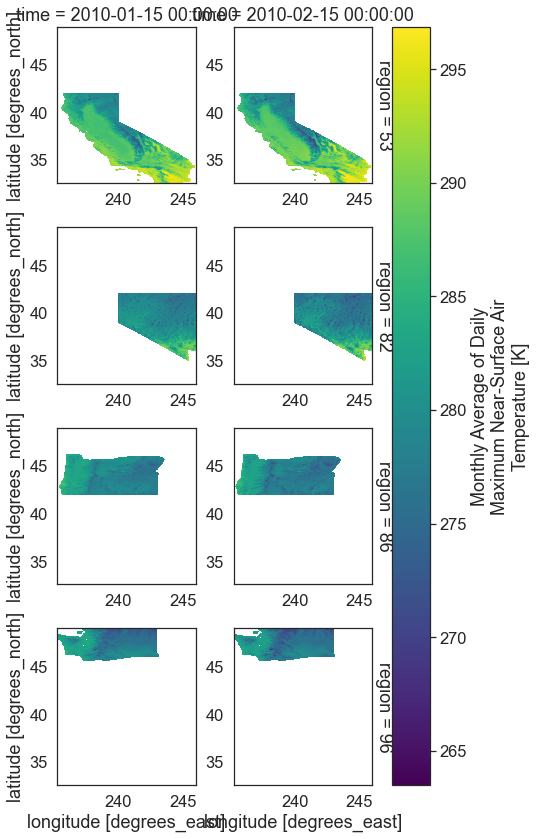

In [39]:
two_months_west_coast.plot(col="time",
                           row="region",
                           sharey=False, sharex=False)
plt.show()

In [40]:
# # Start by extracting a few states from the states_gdf
# # I am using this as a shapefile because i presume some of my students
# # will want to use custom aoi's so i want to teach using a shapefil rather than
# # the regionmask built in shapes as nice as they are :)
# states_gdf["name"]

# cali_or_wash_nev = states_gdf[states_gdf.name.isin(
#     ["California", "Oregon", "Washington", "Nevada"])]

# west_mask = regionmask.mask_3D_geopandas(cali_or_wash_nev,
#                                          monthly_forecast_temp_xr.lon,
#                                          monthly_forecast_temp_xr.lat)
# west_mask

# def get_aoi(shp, world=True):
#     """Takes a geopandas object and converts it to a lat/ lon
#     extent """

#     lon_lat = {}
#     # Get lat min, max
#     aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
#     aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

#     if world:
#         aoi_lon[0] = aoi_lon[0] + 360
#         aoi_lon[1] = aoi_lon[1] + 360
#     lon_lat["lon"] = aoi_lon
#     lon_lat["lat"] = aoi_lat
#     return lon_lat

# west_bounds = get_aoi(cali_or_wash_nev)


# # Slice the data
# start_date = "2010-01-15"
# end_date = "2012-02-15"

# # Subset
# two_months_west_coast = monthly_forecast_temp_xr["air_temperature"].sel(
#     time=slice(start_date, end_date),
#     lon=slice(west_bounds["lon"][0], west_bounds["lon"][1]),
#     lat=slice(west_bounds["lat"][0], west_bounds["lat"][1])).where(west_mask)
# two_months_west_coast

## Calculate Mean Air Temperature by Region
Once you have your data subsetted by region, you can 
calculate summary statistics on the data for each region. 

Below, you calculate the mean air temperature value for the 
time subset that you created above. At this point you could export
the dataframe to a csv file if you want!

In [41]:
summary = two_months_west_coast.groupby("time").mean(["lat", "lon"])
summary.to_dataframe()

air_temperature
time                region                 
2010-01-15 00:00:00 53           286.057922
                    82           280.085175
                    86           279.390350
                    96           278.031158
2010-02-15 00:00:00 53           286.026550
                    82           279.355438
                    86           278.442688
                    96           277.346008

## The Entire Workflow To Subset netcdf 4 Files by Temporal and Spatial Extents

Putting all of the above together, below is an example workflow that you might use to summarize
climate data in netcdf 4 format by region and over time. 

In [42]:
# # This works! - this just shows you that you can also use the region mask existing natural earth regions
# if you want. I kept the geopandas example above just in case people have custom AOI's ...

# import matplotlib.pyplot as plt
# import regionmask
# import xarray as xr

# # Get netcdf file
# data_path_monthly = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_tasmax_BNU-ESM_r1i1p1_rcp45_2006_2099_CONUS_monthly.nc'

# # Open up the data
# ds = xr.open_dataset(data_path_monthly)

# # slice out a few months
# ds_slice = ds.sel(time=slice('2099-10-25', '2099-12-15'))

# # the US states are available here:
# us_states_50 = regionmask.defined_regions.natural_earth.us_states_50
# print(us_states_50)

# # you can select california like so
# california = us_states_50[["CA"]]
# print(california)

# # create a mask
# mask_ca = california.mask(ds)

# mask_ca.plot()

# ds_slice.where(mask_ca)

# # set everything outside of california to NaN
# # California has the number 4
# ds_slice_ca = ds_slice.where(mask_ca == 4)

# # plot the first timestep
# plt.figure()
# ds_slice_ca.air_temperature.isel(time=0).plot()

In [43]:
# Helper Function to extract AOI
def get_aoi(shp, world=True):
    """Takes a geopandas object and converts it to a lat/ lon
    extent """

    lon_lat = {}
    # Get lat min, max
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

    # Handle the 0-360 lon values
    if world:
        aoi_lon[0] = aoi_lon[0] + 360
        aoi_lon[1] = aoi_lon[1] + 360
    lon_lat["lon"] = aoi_lon
    lon_lat["lat"] = aoi_lat
    return lon_lat

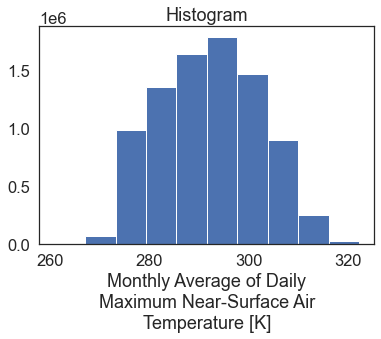

In [44]:
# Here is the entire workflow from start to end

# Download natural earth data which contains state boundaries to generate AOI
et.data.get_data(
    url="https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_1_states_provinces_lakes.zip")

states_path = "earthpy-downloads/ne_50m_admin_1_states_provinces_lakes"
states_path = os.path.join(
    states_path, "ne_50m_admin_1_states_provinces_lakes.shp")

states_gdf = gpd.read_file(states_path)


# Get netcdf file
data_path_monthly = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_tasmax_BNU-ESM_r1i1p1_rcp45_2006_2099_CONUS_monthly.nc'

# Open up the data
with xr.open_dataset(data_path_monthly) as file_nc:
    monthly_forecast_temp_xr = file_nc

# View xarray object
monthly_forecast_temp_xr

# Start by extracting a few states from the states_gdf
# I am using this as a shapefile because i presume some of my students
# will want to use custom aoi's so i want to teach using a shapefil rather than
# the regionmask built in shapes as nice as they are :)
states_gdf["name"]

cali_or_wash_nev = states_gdf[states_gdf.name.isin(
    ["California", "Oregon", "Washington", "Nevada"])]

west_mask = regionmask.mask_3D_geopandas(cali_or_wash_nev,
                                         monthly_forecast_temp_xr.lon,
                                         monthly_forecast_temp_xr.lat)
west_mask


west_bounds = get_aoi(cali_or_wash_nev)


# Slice the data
start_date = "2010-01-15"
end_date = "2020-02-15"

# Subset the data - this is now a dataarray rather than a DataSet
two_months_west_coast = monthly_forecast_temp_xr["air_temperature"].sel(
    time=slice(start_date, end_date),
    lon=slice(west_bounds["lon"][0], west_bounds["lon"][1]),
    lat=slice(west_bounds["lat"][0], west_bounds["lat"][1])).where(west_mask)

# This output is a dataarray
two_months_west_coast

# Plot the data - this produces a single histogram
two_months_west_coast.plot()
plt.show()

Once the data are subsetted, you can begin to create plots and dataframes
with the summary data. 

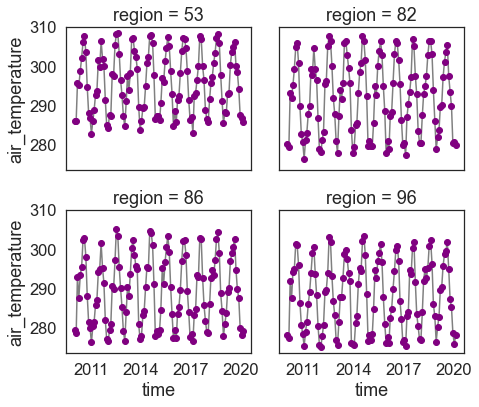

In [45]:
# Keep in mind that as you add more data to your slice, the processing will slow down.
regional_summary = two_months_west_coast.groupby("region").mean(["lat", "lon"])
regional_summary.plot(col="region",
                      marker="o",
                      color="grey",
                      markerfacecolor="purple",
                      markeredgecolor="purple",
                      col_wrap=2)
plt.show()

Export to a dataframe.

In [46]:
two_months_west_coast.groupby("region").mean(["lat", "lon"]).to_dataframe()

air_temperature
time                region                 
2010-01-15 00:00:00 53           286.057922
                    82           280.085175
                    86           279.390350
                    96           278.031158
2010-02-15 00:00:00 53           286.026550
...                                     ...
2020-01-15 00:00:00 96           275.706940
2020-02-15 00:00:00 53           285.709076
                    82           279.856842
                    86           279.198822
                    96           278.026459

[488 rows x 1 columns]